In [21]:
from collections import defaultdict
import copy
import facebook
import io
import matplotlib.pyplot as plt
import networkx as nx
import time
import codecs
%matplotlib inline 

In [22]:
"""
You do not need to run this code. 

This is the code I used to collect "like" data from Facebook.
I include it here as an example that may or may not be helpful for 
your class project.
"""
def snowball(fb, tofind, found, edges, id2name, depth=0, maxdepth=2):
    """
    Given a seed set of users in `tofind`, recursively sample
    additional users that are "liked" by the original set.
    
    tofind....list of user ids to find
    found.....list of user ids we have already found
    edges.....dict from user id A to list of user ids B1,B2,..., where A likes B
    id2name...dict from user id to user name
    depth.....current depth of breadth-first sampling
    maxdepth..maximum depth to reach
    """
    tofind2 = copy.copy(list(tofind))  # make a copy since we modify `tofind` below.
    for userid in tofind2:
        print('getting likes for %s' % userid)
        friends = fb.get_connections(userid, "likes")
        time.sleep(1)  # to avoid rate limits.
        found.add(userid)
        tofind.remove(userid)
        for friend in friends['data']:
            id2name[friend['id']] = friend['name']
            edges[userid].add(friend['id'])
            if friend['id'] not in found:  # add if haven't seen already.
                tofind.add(friend['id'])
        print('%d tofind' % len(tofind))
    if depth < maxdepth:  # if should continue recursively.
        print('recursing with %d to find, %d found, and %d names' %
              (len(tofind), len(found), len(id2name)))
        snowball(fb, tofind, found, edges, id2name, depth+1, maxdepth)
    return edges

if False:  # don't actually run this.
    # see here: https://developers.facebook.com/tools/explorer/
    access_token = '<ENTER YOUR ACCESS TOKEN>'
    # Look at Bill Gates's profile for this example by using his Facebook id.
    user = 'BillGates'
    fb = facebook.GraphAPI(access_token)
    profile = fb.get_object(user)
    tofind = set([profile['id']])
    found = set()
    edges = defaultdict(lambda: set())
    id2name = {profile['id']: profile['name']}

    edges = snowball(fb, tofind, found, edges, id2name, 0, 2)
    
    # Write 'like' edges to a file.
    outf = io.open('edges.txt', 'w', encoding='utf8')
    for user, friends in edges.iteritems():
        for friend in friends:
            outf.write(id2name[user] + u'\t' + id2name[friend] + u'\n')
    outf.close()   


In [23]:
def read_graph():
    """ Read 'edges.txt' into a networkx **undirected** graph.
    Returns:
      A networkx undirected graph.
    """
    G = nx.Graph()
    
    f = codecs.open('edges.txt','r',encoding='utf-8',errors='ignore')
    #    f = open("edges.txt",'r')
    for m in iter(f):
        m = m.split("\t")
        m[0] = m[0].strip()
        m[1] = m[1].strip()
        G.add_node(m[0])
        G.add_node(m[1])
        G.add_edge(m[0],m[1]) 
    return G


        
graph = read_graph()
print('graph has %d nodes and %d edges' % 
      (graph.order(), graph.number_of_edges()))

graph has 5062 nodes and 6060 edges


In [24]:
# Nodes with highest degree.
sorted(graph.degree().items(), key=lambda x: x[1], reverse=True)[:10]


[(u'ONE', 39),
 (u'Bill & Melinda Gates Foundation', 39),
 (u'NPR', 35),
 (u'UN Women', 34),
 (u'Women Deliver', 34),
 (u'The New York Times', 34),
 (u'I fucking love science', 33),
 (u'Global Citizen', 33),
 (u'Melinda Gates', 32),
 (u'Show of Force: Social Good', 32)]

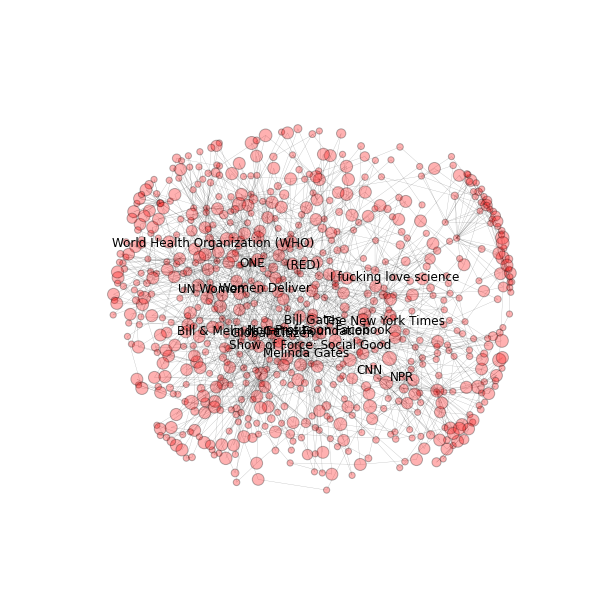

In [25]:
def draw_network(graph, draw_thresh=1, label_thresh=31,
                 min_node_sz=30, max_node_sz=200):
    """
    Draw a graph, filtering the nodes and labels based on degree.
    The size of nodes is proportional to degree.
    
    graph...........a networkx graph
    draw_thresh.....only draw nodes that have degree greater than this.
    label_thresh....only label nodes that have degree greater than this.
    min_node_size...smallest node size
    max_node_size...biggest node size
    """
    degrees = graph.degree()
    labels = {n: n for n, d in degrees.items() if d > label_thresh}
    plt.figure(figsize=(10,10))
    nodes_to_draw = [name for name, degree in degrees.items() if degree > draw_thresh]
    maxdegree = max(degrees.values())
    sz_range = max_node_sz - min_node_sz
    sizes = [min_node_sz + (1. * degrees[n] / maxdegree * sz_range)
             for n in nodes_to_draw]
    subgraph = graph.subgraph(nodes_to_draw)
    nx.draw_networkx(subgraph, alpha=.3, width=.3,
                     labels=labels, node_size=sizes)
    plt.axis("off")
    plt.show()
    
draw_network(graph)


In [26]:
def get_subgraph(graph, min_degree):
    """Return a subgraph containing nodes whose degree is
    greater than min_degree.
    Args:
      graph........a networkx graph
      min_degree...degree threshold
    Returns:
      a networkx graph, filtered as defined above.
    """
    ###TODO
    ###
    node = []
    print graph
    for m in graph.nodes():
    #    print m
        if graph.degree(m) > min_degree:
            node.append(m)
            
    k = graph.subgraph(node)      
    return k

            

subgraph = get_subgraph(graph, 1)
print('subgraph has %d nodes and %d edges' % 
      (subgraph.order(), subgraph.number_of_edges()))


subgraph has 712 nodes and 1710 edges


In [27]:
def girvan_newman(G, minsize=30, maxsize=100):
    """ Recursive implementation of the girvan_newman algorithm.
    This involves a couple modifications from our class code.
    
    - Rather than recompute betweenness after each edge is removed,
      only compute betweenness once per call to this method. That is,
      compute betweenness once, remove edges until multiple connected
      components are formed, then recurse.
      
    - Rather than return all communities, only return communities with
      size >= minsize and <= maxsize. To do this, halt recursion
      when this condition is met. E.g., if a split results in
      communities of size 50 and 200, the community of size 50
      will be added to the result set, while the community of size
      200 will be split again using a recursive call to this function.
      Similarly, if a split results in communities of size 50 and 1, 
      the size 50 community will be returned, while the size 1 community
      will not.
      
    **Note that the above procedure means that not all nodes will be
    assigned a community.
    
    Args:
    G.........a networkx graph
    minsize...the smallest acceptable size for a community
    maxsize...the largest acceptable size for a community

    Returns:
    A list of all discovered communities. This list is a list 
    of lists of strings. E.g., [['A', 'B'], ['C', 'D']] is a result
    containing two communities ((A,B) and (C,D)).
    """
    ###TODO
    ###
    betweenness_measure = nx.edge_betweenness_centrality(G)
    ctr=0
    remove_node=0
    components = [c for c in nx.connected_component_subgraphs(G)]
    k=sorted( betweenness_measure.items(), key=lambda x: x[1], reverse=True)
    while len(components) == 1:
        edge_remove = k[0][0]
        k.remove(k[0])
        G.remove_edge(edge_remove[0],edge_remove[1])
        ctr=ctr+1
        components = [c for c in nx.connected_component_subgraphs(G)]
    print "removed %d edges" %ctr
    lencomp = [len(c) for c in components]
    print "component sizes =",
    print lencomp
    
    result = []
#    print maxsize
#    print minsize
    for c in components:            
        if len(c)> maxsize:               
            result.extend(girvan_newman(c,minsize,maxsize))
        elif (len(c) <= maxsize)&(len(c) >= minsize):
            print "stopping for",len(c)
            result.extend([c.nodes()])
    
    return result
    

result = girvan_newman(subgraph.copy(), minsize=30, maxsize=100)





 




removed 87 edges
component sizes = [701, 11]
removed 3 edges
component sizes = [695, 6]
removed 6 edges
component sizes = [694, 1]
removed 2 edges
component sizes = [693, 1]
removed 3 edges
component sizes = [692, 1]
removed 6 edges
component sizes = [691, 1]
removed 2 edges
component sizes = [689, 2]
removed 2 edges
component sizes = [688, 1]
removed 1 edges
component sizes = [641, 47]
removed 188 edges
component sizes = [634, 7]
removed 4 edges
component sizes = [633, 1]
removed 12 edges
component sizes = [632, 1]
removed 8 edges
component sizes = [631, 1]
removed 6 edges
component sizes = [630, 1]
removed 2 edges
component sizes = [629, 1]
removed 2 edges
component sizes = [628, 1]
removed 1 edges
component sizes = [600, 28]
removed 6 edges
component sizes = [599, 1]
removed 6 edges
component sizes = [598, 1]
removed 2 edges
component sizes = [597, 1]
removed 1 edges
component sizes = [557, 40]
removed 25 edges
component sizes = [554, 3]
removed 13 edges
component sizes = [553, 1]
r

In [28]:
print('final cluster sizes:')
[len(x) for x in result]

final cluster sizes:


[100, 68, 100, 32, 40, 47]

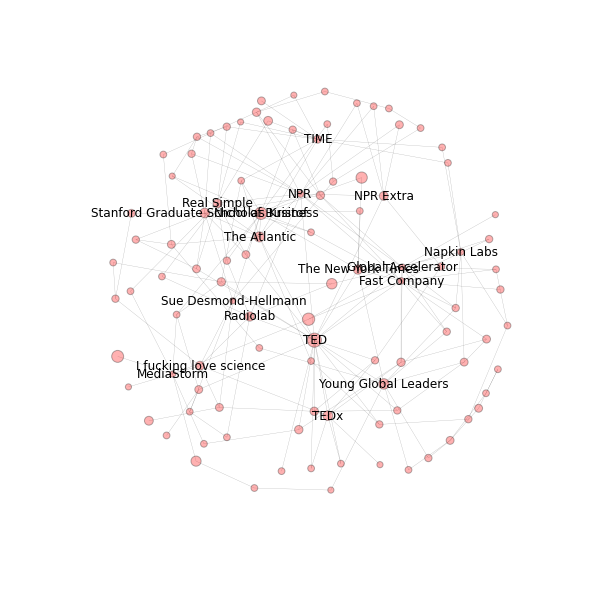

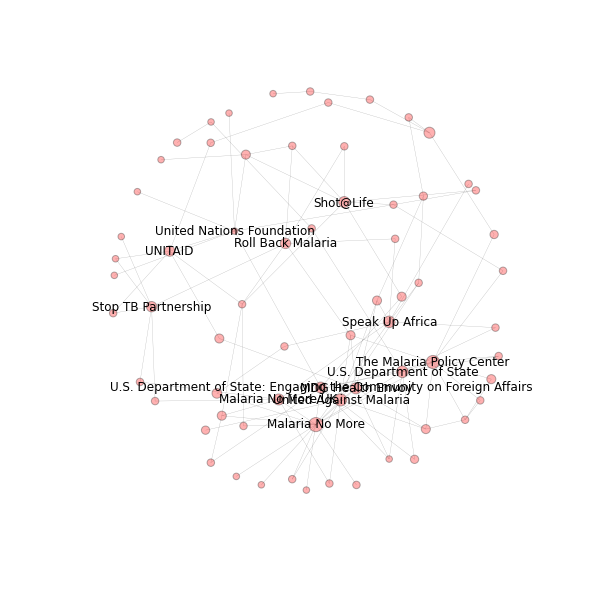

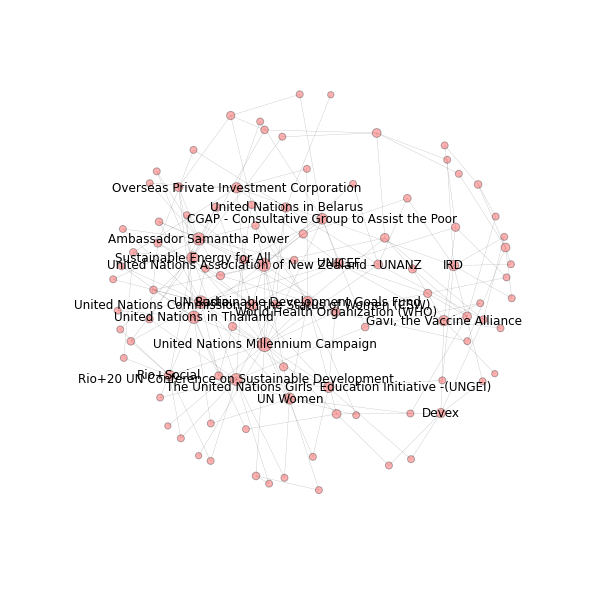

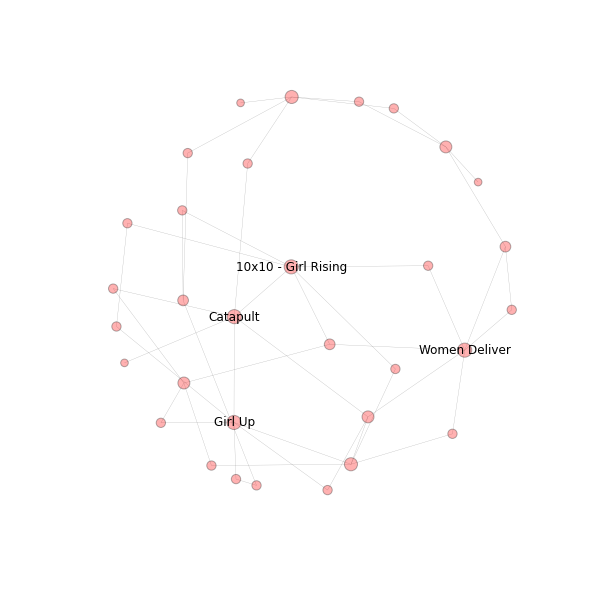

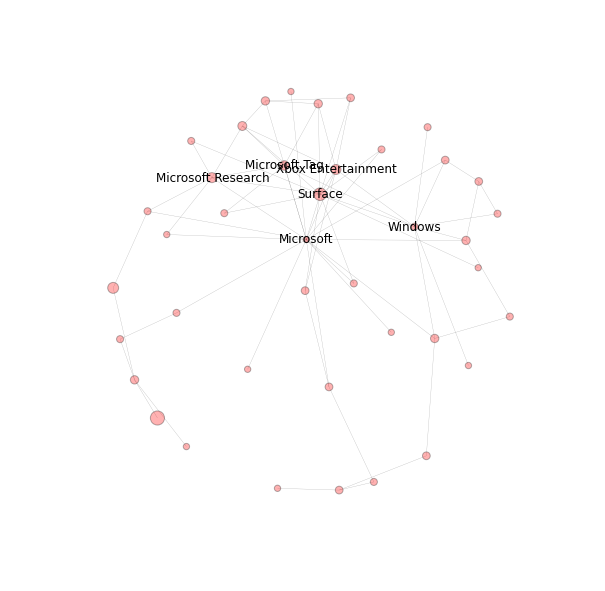

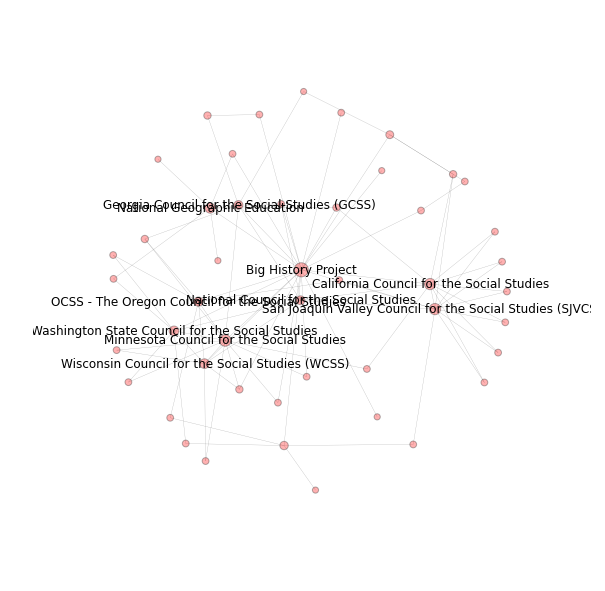

In [29]:

for cluster in result:
    draw_network(graph.subgraph(cluster), label_thresh=5, draw_thresh=0)

In [30]:
def volume(nodes, graph):
    """
    Compute the volume for a set of `nodes`, which
    is the number of edges in `graph` with at least one end in
    nodes.
    Args:
      nodes...a list of strings for the nodes to compute the volume of.
      graph...a networkx graph
    """
    ###TODO
    ###  
    count = 0

   
    for j in graph.edges():
        if j[0] in nodes or j[1] in nodes:
            count = count + 1
 
    return count


def cut(S, T, graph):
    
    """
    Compute the cut-set of the cut (S,T), which is
    the set of edges that have one endpoint in S and
    the other in T.
    Args:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An int representing the cut-set.
    """
    ###TODO
    ###
    l=[]                     
            
    for e in graph.edges():
        if (e[0] in S and e[1] in T) or (e[1] in S and e[0] in T):
            l.append(e)
        
    return len(l)

def norm_cut_v(S, T, graph):
    """
    The normalized cut value for the cut S/T. (See lec06.)
    Args:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An float representing the normalized cut value
    """
    ###TODO
    ###
    v1= float(volume(T,graph))
    v2= float(volume(S,graph))
    c= float(cut(S,T,graph))
    return ((c/v1)+(c/v2))
    
def score_clusters(clusters, graph):
    """
    Compute the normalized cut value for each cluster returned 
    by the girvan newman algorithm above. To compute the value
    for one cluster, we consider the cut in which S is the
    proposed cluster, and T are all the other nodes in the graph.
    E.g., if the graph has nodes [A,B,C,D,E], and the proposed cluster
    is [A,B], then the cut value is computed on the cut
    S=[A,B], T=[C,D,E].
    
    Args:
      clusters....list of lists of strings representing the clusters
                  returned by the Girvan Newman algorithm.
      graph.......a networkx graph
    Returns:
      list of floats containing the normalized cut values for each cluster.
    """
    ###TODO
    ###
    l =[]
    for p in clusters:
        t=[]
        for k in graph.nodes():
            if k not in p:
                t.append(k)
                v = norm_cut_v(p,t,graph)
        l.append(v)      
    return l
    

score_clusters(result, subgraph)

[0.5394522186431889,
 0.7112986541855564,
 0.6125866583993509,
 0.7394497863247863,
 0.38487710745480397,
 0.169372331833391]

In [31]:
test_node = 'Bill Gates'
G_train = subgraph.copy()
edges_to_rem = subgraph.edges(test_node)[:10]
G_train.remove_edges_from(edges_to_rem)
print('original graph has %d nodes and %d edges' % 
      (subgraph.order(), subgraph.number_of_edges()))
print('train graph has %d nodes and %d edges' % 
      (G_train.order(), G_train.number_of_edges()))

original graph has 712 nodes and 1710 edges
train graph has 712 nodes and 1700 edges


In [32]:
print('removed the following edges:')
edges_to_rem

removed the following edges:


[('Bill Gates', u'Khan Academy'),
 ('Bill Gates', u'Pau Gasol'),
 ('Bill Gates', u'Big History Project'),
 ('Bill Gates', u'PATH'),
 ('Bill Gates', u'Vaccines Today'),
 ('Bill Gates', u'World Health Organization'),
 ('Bill Gates', u'TED'),
 ('Bill Gates', u'Bill & Melinda Gates Foundation'),
 ('Bill Gates', u'ONE'),
 ('Bill Gates', u'Sue Desmond-Hellmann')]

In [33]:
# I've done this one for you.
def evaluate(scores, graph, n=10):
    """ Returns the accuracy of the predicted link scores, filtering
        to the top `n` results.
    Args:
      scores....list of ((n1, n2), score) tuples, representing the 
                score assigned to edge (n1, n2)
      graph.....a networkx graph
      n.........Evaluate the top n values in scores.
    Returns:
      A float indicating the proportion of the top ranked edges
      in scores that are present in the graph.
    """
    predicted_edges = [x[0] for x in sorted(scores, key=lambda x: x[1], reverse=True)[:n]]
    return 1. * len([x for x in predicted_edges if graph.has_edge(*x)]) / len(predicted_edges)

In [34]:
def jaccard(graph, node):
    """ Jaccard similarity. Note that we don't
    return scores for edges that already appear in the graph.
    """
    scores = []
    neighborsi = set(graph.neighbors(node))
    for n in graph.nodes():
        if n != node and not graph.has_edge(node, n):
            neighborsj = set(graph.neighbors(n))
            score = 1. * (len(neighborsi & neighborsj)) / (len(neighborsi | neighborsj))
            scores.append(((node, n), score))
    return scores

jaccard_scores = jaccard(G_train, test_node)
print('jaccard accuracy=%.3f' % evaluate(jaccard_scores, subgraph, n=10))

jaccard accuracy=0.200


In [35]:
print('%d jaccard scores' % len(jaccard_scores))
print('top 5 recommendations:')
[x[0][1] for x in sorted(jaccard_scores, key=lambda x: x[1], reverse=True)[:5]]

690 jaccard scores
top 5 recommendations:


[u'Global Citizen',
 u'Girl Effect',
 u'Show of Force: Social Good',
 u'Sue Desmond-Hellmann',
 u'Global Poverty Project']

In [36]:
def jaccard_wt(graph, node):
    """
    The weighted jaccard score, defined above.
    Args:
      graph....a networkx graph
      node.....a node to score potential new edges for.
    Returns:
      A list of ((node, ni), score) tuples, representing the 
                score assigned to edge (node, ni)
                (note the edge order)
    """
    ###TODO
    ###
    scores = []
    neighborsi = set(graph.neighbors(node))
    for n in graph.nodes():
        if n != node and not graph.has_edge(node, n):
            neighborsj = set(graph.neighbors(n))
            
            nm=0.0
            for i in neighborsi:
                for j in neighborsj:
                    if i == j:
                        nm = nm + ( 1.0/float(graph.degree(i)))
            dn1=0.0
            for i in neighborsi:
                dn1 = dn1+graph.degree(i)
            dn1 = 1.0/float(dn1)
            dn2=0.0
            for j in neighborsj:
                dn2 = dn2+graph.degree(j)
            
            dn2 = 1.0/float(dn2)
            score = nm/(dn1 + dn2)
            scores.append(((node, n), score))
    return scores  
            

jaccard_wt_scores = jaccard_wt(G_train, test_node)
print('jaccard_wt accuracy=%.3f' % evaluate(jaccard_wt_scores, subgraph, n=10))

jaccard_wt accuracy=0.400


In [37]:
print('%d jaccard_wt_scores' % len(jaccard_wt_scores))
print('top 5 recommendations:')
[x[0][1] for x in sorted(jaccard_wt_scores, key=lambda x: x[1], reverse=True)[:5]]

690 jaccard_wt_scores
top 5 recommendations:


[u'Bill & Melinda Gates Foundation',
 u'Global Citizen',
 u'ONE',
 u'PATH',
 u'Sue Desmond-Hellmann']

In [38]:
import json
outf = open('output.txt', 'wt')

exgraph = nx.Graph()
exgraph.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'),
                        ('B', 'D'), ('D', 'E'), ('D', 'F'),
                        ('D', 'G'), ('E', 'F'), ('G', 'F')])                                        
[sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=2)]

json.dump({'graph_order': read_graph().order(),
           'graph_edges': len(read_graph().edges()),
           'subgraph_order': get_subgraph(read_graph(), 1).order(),
           'subgraph_edges': len(get_subgraph(read_graph(), 1).edges()),
           'subgraph_order_2': get_subgraph(read_graph(), 2).order(),
           'subgraph_edges_2': len(get_subgraph(read_graph(), 2).edges()),
           'gn_1_2': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=2)]),
           'gn_2_3': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=2, maxsize=3)]),
           'gn_1_4': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=4)]),
           'volume1': volume(['A', 'B', 'C', 'D'], exgraph),
           'cut1': cut(['A', 'B', 'C', 'D'], ['E', 'F', 'G'], exgraph),
           'ncv1': norm_cut_v(['A', 'B', 'C', 'D'], ['E', 'F', 'G'], exgraph),
           'score_clusters': score_clusters(result, subgraph),
           'gn_sizes': [len(x) for x in result],
           'jaccard_wt': sorted(jaccard_wt(G_train, test_node),
                                key=lambda x: x[1], reverse=True)[:30]
          }, outf, indent=2, sort_keys=True)
outf.close()

removed 1 edges
component sizes = [3, 4]
removed 2 edges
component sizes = [2, 1]
stopping for 2
stopping for 1
removed 2 edges
component sizes = [1, 3]
stopping for 1
removed 2 edges
component sizes = [2, 1]
stopping for 2
stopping for 1




removed 1 edges
component sizes = [3, 4]
removed 2 edges
component sizes = [2, 1]
stopping for 2
stopping for 1
removed 2 edges
component sizes = [1, 3]
stopping for 1
removed 2 edges
component sizes = [2, 1]
stopping for 2
stopping for 1
removed 1 edges
component sizes = [3, 4]
stopping for 3
removed 2 edges
component sizes = [1, 3]
stopping for 3
removed 1 edges
component sizes = [3, 4]
stopping for 3
stopping for 4
